# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD002.csv')

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [6]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [7]:
agg_features = []
using_sensor = [
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    features = {'unit_number': unit}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    # RUL도 unit 단위 최대값으로 설정
    features['RUL'] = unit_data['RUL'].max()

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [8]:
agg_df.head()

,unit_number,s_1_mean,s_1_std,s_1_min,s_1_max,s_1_last,s_1_median,s_1_trend,s_2_mean,s_2_std,...,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend,RUL
0,1,471.633154,27.183640,445.0,518.67,445.00,462.54,0.050979,578.220403,38.080742,...,14.780,0.020858,12.190332,6.075709,6.2285,23.3464,6.2285,8.8740,0.012391,148
1,2,472.272639,26.174906,445.0,518.67,445.00,462.54,-0.029663,578.687881,37.092719,...,14.850,-0.010690,12.273477,5.841726,6.1978,23.4306,6.2615,8.9174,-0.006350,268
2,3,471.465388,25.401296,445.0,518.67,445.00,462.54,0.033211,578.227136,35.644699,...,14.880,0.010264,12.166150,5.582113,6.1991,23.4735,6.3349,8.9190,0.006234,205
3,4,472.886851,27.033974,445.0,518.67,518.67,462.54,0.009071,580.148383,37.750376,...,14.860,0.003359,12.480000,6.033641,6.2183,23.4181,22.9717,8.9373,0.001878,234
4,5,471.514935,24.980474,445.0,518.67,445.00,462.54,-0.002945,576.915714,36.043935,...,14.895,-0.001272,12.221888,5.604065,6.1984,23.4725,6.3906,8.9232,-0.000881,153


In [9]:
x = agg_df.drop(['unit_number','RUL'], axis=1)
y = agg_df['RUL']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **XGBoost**

In [10]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_val)

In [11]:
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 36.932, MAE: 26.554


## **LightGBM**

In [12]:
lgb_model = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, verbose=-1)
lgb_model.fit(x_train, y_train)
lgb_pred = lgb_model.predict(x_val)

In [13]:
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 26.767, MAE: 21.306


# **Predict RUL**

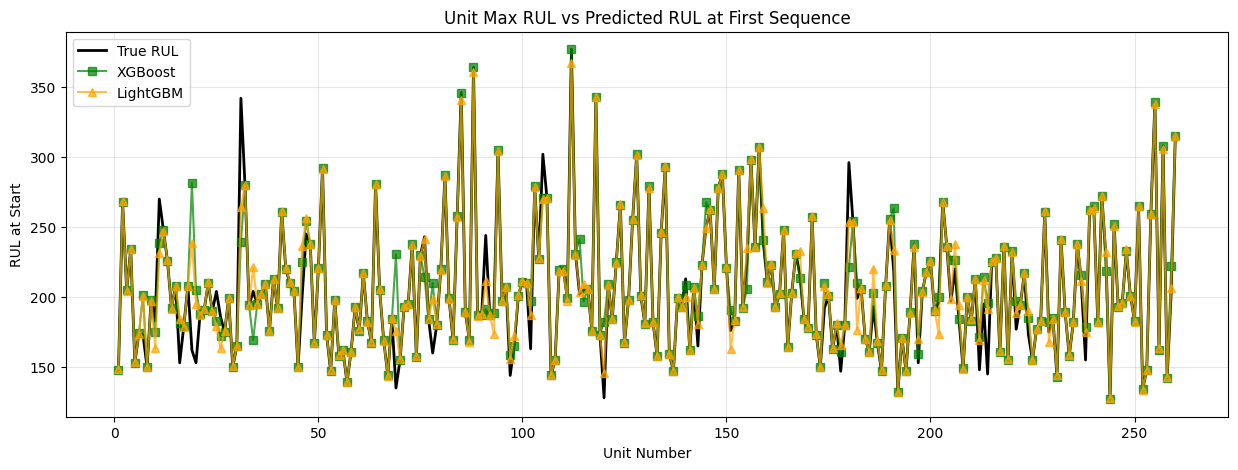

In [14]:
unit_ids = agg_df['unit_number']
true_max_rul = agg_df['RUL']

xgb_pred_full = xgb_model.predict(x)
lgb_pred_full = lgb_model.predict(x)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# **Test**

In [15]:
test_df = pd.read_csv('./test_FD002.csv')
rul_df = pd.read_csv('./RUL_FD002.csv')

In [16]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21',
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740


In [17]:
agg_features = []
using_sensor = [
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    features = {'unit_number': unit}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [18]:
agg_df.head()

,unit_number,s_1_mean,s_1_std,s_1_min,s_1_max,s_1_last,s_1_median,s_1_trend,s_2_mean,s_2_std,...,s_20_last,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend
0,1,472.752907,26.567691,445.0,518.67,489.05,462.54,0.050329,579.238682,37.795646,...,28.30,14.835,0.018853,12.394515,5.918056,6.1964,23.4068,17.0934,8.91100,0.011225
1,2,468.179636,26.264097,445.0,518.67,518.67,462.54,0.113587,573.677091,36.293131,...,38.82,14.760,0.019235,11.528038,5.944379,6.2304,23.3510,23.3463,8.84780,0.012169
2,3,475.060788,27.118099,445.0,518.67,449.44,462.54,-0.040523,582.964788,37.926567,...,14.75,15.060,-0.019664,13.080335,6.116023,6.2533,23.4204,8.9589,8.97000,-0.011671
3,4,472.189651,25.968982,445.0,518.67,491.19,462.54,0.004163,577.534419,37.602058,...,24.22,14.830,0.002625,12.261906,5.906736,6.2177,23.3640,14.6814,8.92065,0.002104
4,5,473.211216,26.089794,445.0,518.67,445.00,462.54,-0.005701,579.376689,37.465465,...,10.34,14.900,0.001511,12.519247,5.800270,6.2111,23.4841,6.3601,8.94230,0.001146


In [19]:
x_test = agg_df.drop(['unit_number'], axis=1)
y_test = rul_df['RUL']

In [20]:
xgb_pred = xgb_model.predict(x_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 125.209, MAE: 108.381


In [21]:
lgb_pred = lgb_model.predict(x_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 116.540, MAE: 97.985


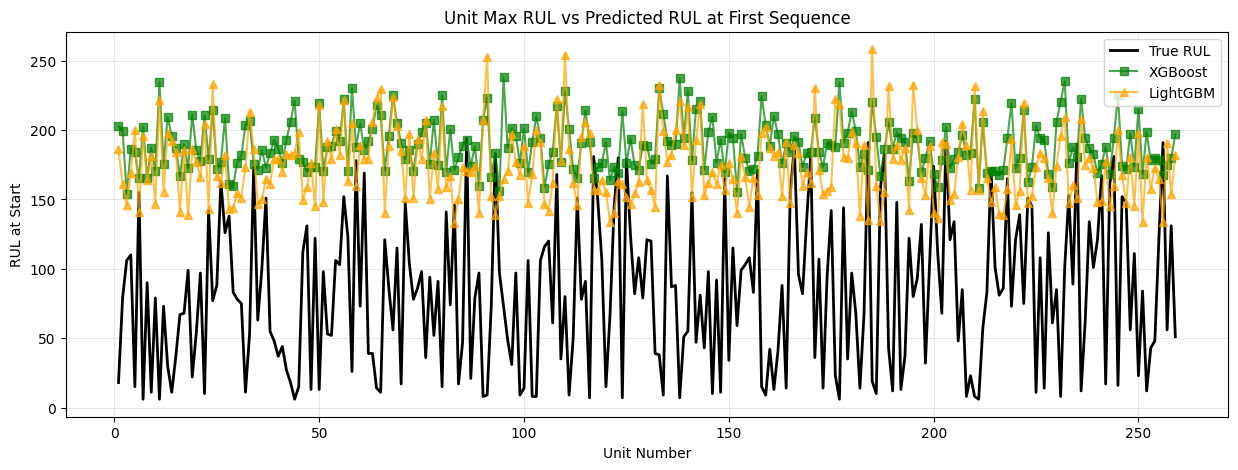

In [22]:
# 주어진 Test Set은 Train Set과 달리 고장 직전 시점까지가 아닌 중간 시점이 주어짐
# 따라서 정확한 고장 시점을 구하기 위해선 전체 통계량이 아닌 시점마다 생성해야함
unit_ids = agg_df['unit_number']
true_max_rul = rul_df['RUL']

xgb_pred_full = xgb_model.predict(x_test)
lgb_pred_full = lgb_model.predict(x_test)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()